In [129]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import session_info
import os
import anndata
session_info.show()
sc.set_figure_params(dpi=100, dpi_save=300, format='svg')

In [10]:
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="109")
genes = ensdb.genes()
genes.head(3)

,gene_id,gene_name,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript
0,ENSG00000000003,TSPAN6,protein_coding,100627108,100639991,X,-1,chromosome,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],ENSG00000000003.15,ENST00000373020
1,ENSG00000000005,TNMD,protein_coding,100584936,100599885,X,1,chromosome,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],ENSG00000000005.6,ENST00000373031
2,ENSG00000000419,DPM1,protein_coding,50934867,50959140,20,-1,chromosome,dolichyl-phosphate mannosyltransferase subunit...,ENSG00000000419.14,ENST00000371588


Aims:
- Compare T21 vs Healthy cell types using DEG analysis
- A problem is that all the T21 samples are female, so this will capture sex-specific DEGs --> will annotate `sex_specific` genes by comparing M vs F in healthy atlas first
- Another issue is the ages: The T21 samples are PCW13/14 only. Therefore DEGs will capture age changes. To limit this I can subset healthy data to similar ages.

In [11]:
auc_gene=pd.read_csv("/nfs/team205/heart/pyscenic/plus/AUCscore/T21-Healthy_Cardiomyocytes_eRegulon_AUC_gene.csv", index_col=0)
auc_gene

,AHCTF1_extended_+_(291g),ARID3A_+_(1426g),ARID5A_extended_+_(18g),ATF1_+_(554g),ATF2_+_(455g),ATF3_+_(361g),ATF4_+_(820g),ATF5_+_(74g),BACH2_+_(642g),BCL11A_+_(131g),...,ZNF880_+_(752g),ZNF891_+_(10g),ZNF8_+_(11g),ZNF90_+_(678g),ZNF91_+_(149g),ZNF93_+_(244g),ZSCAN18_+_(85g),ZSCAN29_+_(181g),ZSCAN31_+_(11g),ZXDC_+_(49g)
barcode,,,,,,,,,,,,,,,,,,,,,
BHF_F_Hea11064670_BHF_F_Hea11031823_TTGCTTAGTGAGACTC-1,0.033035,0.046529,0.114086,0.136766,0.161287,0.191078,0.083735,0.054372,0.249205,0.152167,...,0.017629,0.000000,0.000000,0.050150,0.216999,0.071204,0.055828,0.007738,0.000000,0.030200
BHF_F_Hea11064670_BHF_F_Hea11031823_GTACACCCATCCCTCA-1,0.043631,0.059707,0.083455,0.092236,0.125501,0.148318,0.105466,0.085947,0.192585,0.112564,...,0.030125,0.036393,0.020020,0.062982,0.151113,0.062055,0.060347,0.010244,0.000000,0.029174
BHF_F_Hea11064670_BHF_F_Hea11031823_GGTCGGTTCTTAGGAC-1,0.054142,0.040900,0.068792,0.126114,0.160940,0.190901,0.065718,0.075757,0.242185,0.099337,...,0.022292,0.000000,0.000000,0.050842,0.195016,0.070743,0.078875,0.003508,0.000000,0.029341
BHF_F_Hea11064670_BHF_F_Hea11031823_CGATCCTTCTTGTCCA-1,0.038706,0.038358,0.074347,0.111676,0.137244,0.170661,0.079161,0.079235,0.215758,0.090185,...,0.024613,0.000000,0.015748,0.059443,0.161441,0.052855,0.067779,0.002026,0.048336,0.038530
BHF_F_Hea11064670_BHF_F_Hea11031823_GCTCAACCAGGCTGTT-1,0.063272,0.052566,0.084912,0.111240,0.175490,0.155626,0.077766,0.058906,0.193381,0.103875,...,0.026489,0.000000,0.000000,0.057395,0.172193,0.098558,0.054491,0.003804,0.000000,0.021378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BHF_F_Hea13188327_BHF_F_Hea13187629_AGCTAGTTCTAACCAA-1,0.043303,0.027690,0.097116,0.078456,0.075216,0.080826,0.037740,0.049668,0.107999,0.107959,...,0.028155,0.099672,0.000000,0.037323,0.088829,0.056725,0.060643,0.031785,0.000000,0.050273
BHF_F_Hea13188327_BHF_F_Hea13187629_ACAGCCGGTCTCAGCC-1,0.049426,0.044312,0.134123,0.066606,0.072557,0.080431,0.045167,0.049033,0.095456,0.099028,...,0.026315,0.000000,0.000000,0.034690,0.124198,0.043346,0.022880,0.017067,0.064531,0.018847
BHF_F_Hea13188327_BHF_F_Hea13187629_CGATTTGCAGCTAACC-1,0.044467,0.028566,0.147632,0.067354,0.114407,0.067215,0.026591,0.051743,0.105066,0.064276,...,0.026992,0.078251,0.000000,0.029119,0.089427,0.019995,0.048010,0.015285,0.000000,0.021523


# Read in adata

In [28]:
adata = sc.read("/nfs/team205/heart/anndata_objects/Foetal/trisomy21/AtlasT21IntegratedRaw.h5ad")
adata

AnnData object with n_obs × n_vars = 373831 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'MidGrainModified', 'leiden', 'original_or_new', 'age_days', 'diagnosis', 'batch', 'cell_type', 'scANVI_predictions', 'coarse_pred

In [29]:
# make a label for later comparison
adata.obs['fine_grain_T21_status']=adata.obs['fine_grain_integrated'].astype('str')+'_'+adata.obs['diagnosis'].astype('str')
adata.obs['fine_grain_T21_status'] = adata.obs['fine_grain_T21_status'].astype('category')

adata.obs['mid_grain_T21_status']=adata.obs['mid_grain_integrated'].astype('str')+'_'+adata.obs['diagnosis'].astype('str')
adata.obs['mid_grain_T21_status'] = adata.obs['mid_grain_T21_status'].astype('category')

In [30]:
adata.X.data

array([1., 1., 5., ..., 2., 1., 1.], dtype=float32)

In [31]:
celltype = 'Cardiomyocytes'
celltype_column = 'coarse_grain'

# subset celltype
adata = adata[adata.obs[celltype_column]==celltype]

# subset multiome
adata = adata[adata.obs['kit_10x']=='Multiome-v1']
adata.shape

(85617, 36601)

In [32]:
# make anndata of AUC score
adata_reg = anndata.AnnData(
    X = auc_gene,
    obs = adata.obs,
    var = pd.DataFrame(auc_gene.columns).set_index(0)
)
adata_reg

AnnData object with n_obs × n_vars = 85617 × 374
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'MidGrainModified', 'leiden', 'original_or_new', 'age_days', 'diagnosis', 'batch', 'cell_type', 'scANVI_predictions', 'coarse_predict

# Compare T21 and healthy cell states

In [33]:
# subset to similar ages, so we are not capturing
print(adata_reg.shape)
adata_reg = adata_reg[(adata_reg.obs.age_days >= 75) & (adata_reg.obs.age_days <= 105)]
print(adata_reg.shape)

(85617, 374)
(65279, 374)


## LvCMcompact

In [100]:
all_cell_types=adata_reg.obs.fine_grain_T21_status.unique().tolist()

list_of_cell_types=[
    'VentricularCardiomyocytesLeftCompact',
    #'VentricularCardiomyocytesLeftTrabeculated',
    #'VentricularCardiomyocytesRightCompact',
    #'VentricularCardiomyocytesRightTrabeculated',
]

groups = [cell for cell in all_cell_types if any(term in cell for term in list_of_cell_types)]
groups

['VentricularCardiomyocytesLeftCompact_Atlas',
 'VentricularCardiomyocytesLeftCompact_T21']

In [101]:
tmp_adata=adata_reg[adata_reg.obs.fine_grain_T21_status.isin(groups)]
print(tmp_adata.shape)
#tmp_adata=tmp_adata[:,~adata.var.sex_chromosome] # probably better to keep all genes in, then filter results for sex_specific
#print(tmp_adata.shape)

sc.tl.rank_genes_groups(tmp_adata,
                        groupby='fine_grain_T21_status',
                       groups=groups)

(13684, 374)


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


### REDUCED in T21

In [102]:
print("These genes are HIGH in "+groups[0]+" and LOW in "+groups[1])
df=sc.get.rank_genes_groups_df(tmp_adata,group=groups[0],pval_cutoff=0.01,log2fc_min=0)
#df=df.merge(sex_genes.drop_duplicates('gene_name')[['sex_specific','seq_name','sex_chromosome','description']], left_on='names', right_index=True,how='left')
down=df.set_index('names')
down

These genes are HIGH in VentricularCardiomyocytesLeftCompact_Atlas and LOW in VentricularCardiomyocytesLeftCompact_T21


,scores,logfoldchanges,pvals,pvals_adj
names,,,,
BHLHE40_+_(558g),70.878410,0.430124,0.000000,0.000000
HEY2_+_(297g),67.726295,0.347539,0.000000,0.000000
PPARA_+_(563g),67.457298,0.287069,0.000000,0.000000
MEF2D_+_(1003g),65.338722,0.246313,0.000000,0.000000
MAX_+_(633g),63.411869,0.242420,0.000000,0.000000
...,...,...,...,...
IRF1_+_(10g),3.223857,0.091092,0.001271,0.001601
HMBOX1_+_(115g),3.139757,0.016510,0.001698,0.002131
ZNF580_+_(229g),3.128864,0.035099,0.001763,0.002206


### INCREASED in T21

In [103]:
print("These genes are LOW in "+groups[0]+" and HIGH in "+groups[1])
df=sc.get.rank_genes_groups_df(tmp_adata,group=groups[1],pval_cutoff=0.01,log2fc_min=0)
#df=df.merge(sex_genes.drop_duplicates('gene_name')[['sex_specific','seq_name','sex_chromosome','description']], left_on='names', right_index=True,how='left')
up=df.set_index('names')
up=up.sort_values('scores', ascending=False)
up

These genes are LOW in VentricularCardiomyocytesLeftCompact_Atlas and HIGH in VentricularCardiomyocytesLeftCompact_T21


,scores,logfoldchanges,pvals,pvals_adj
names,,,,
MEF2C_+_(1438g),69.858955,0.283939,0.000000,0.000000
TRPS1_+_(840g),68.193161,0.306511,0.000000,0.000000
PBX3_+_(548g),64.009796,0.326149,0.000000,0.000000
NFIB_+_(2378g),63.149345,0.248136,0.000000,0.000000
SP3_+_(2103g),58.910889,0.263808,0.000000,0.000000
...,...,...,...,...
NR2F6_+_(199g),3.660711,0.041974,0.000254,0.000325
TBX20_+_(1056g),3.641442,0.013261,0.000273,0.000348
MAZ_+_(2146g),3.286107,0.029934,0.001021,0.001290


## Make lists of top T21 and Atlas AUC score for this cell type

In [104]:
LvCMtopT21=up.head(10)
LvCMtopT21=LvCMtopT21.index.tolist()

LvCMtopAtlas=down.head(10)
LvCMtopAtlas=LvCMtopAtlas.index.tolist()

## RvCMcompact

In [105]:
all_cell_types=adata_reg.obs.fine_grain_T21_status.unique().tolist()

list_of_cell_types=[
    #'VentricularCardiomyocytesLeftCompact',
    #'VentricularCardiomyocytesLeftTrabeculated',
    'VentricularCardiomyocytesRightCompact',
    #'VentricularCardiomyocytesRightTrabeculated',
]

groups = [cell for cell in all_cell_types if any(term in cell for term in list_of_cell_types)]
groups

['VentricularCardiomyocytesRightCompact_Atlas',
 'VentricularCardiomyocytesRightCompact_T21']

In [106]:
tmp_adata=adata_reg[adata_reg.obs.fine_grain_T21_status.isin(groups)]
print(tmp_adata.shape)
#tmp_adata=tmp_adata[:,~adata.var.sex_chromosome] # probably better to keep all genes in, then filter results for sex_specific
#print(tmp_adata.shape)

sc.tl.rank_genes_groups(tmp_adata,
                        groupby='fine_grain_T21_status',
                       groups=groups)

(9993, 374)


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


### REDUCED in T21

In [107]:
print("These genes are HIGH in "+groups[0]+" and LOW in "+groups[1])
df=sc.get.rank_genes_groups_df(tmp_adata,group=groups[0],pval_cutoff=0.01,log2fc_min=0)
#df=df.merge(sex_genes.drop_duplicates('gene_name')[['sex_specific','seq_name','sex_chromosome','description']], left_on='names', right_index=True,how='left')
down=df.set_index('names')
down

These genes are HIGH in VentricularCardiomyocytesRightCompact_Atlas and LOW in VentricularCardiomyocytesRightCompact_T21


,scores,logfoldchanges,pvals,pvals_adj
names,,,,
RXRA_+_(883g),62.701347,0.266550,0.000000,0.000000
MAX_+_(633g),60.547081,0.282482,0.000000,0.000000
BHLHE40_+_(558g),59.462379,0.381587,0.000000,0.000000
PPARA_+_(563g),54.903248,0.308716,0.000000,0.000000
HEY2_+_(297g),52.607765,0.325474,0.000000,0.000000
...,...,...,...,...
ZNF439_+_(12g),3.028215,0.042140,0.002470,0.002990
ZNF580_+_(229g),2.960595,0.036199,0.003085,0.003722
ELF2_+_(904g),2.818093,0.014293,0.004848,0.005793


### INCREASED in T21

In [108]:
print("These genes are LOW in "+groups[0]+" and HIGH in "+groups[1])
df=sc.get.rank_genes_groups_df(tmp_adata,group=groups[1],pval_cutoff=0.01,log2fc_min=0)
#df=df.merge(sex_genes.drop_duplicates('gene_name')[['sex_specific','seq_name','sex_chromosome','description']], left_on='names', right_index=True,how='left')
up=df.set_index('names')
up=up.sort_values('scores', ascending=False)
up

These genes are LOW in VentricularCardiomyocytesRightCompact_Atlas and HIGH in VentricularCardiomyocytesRightCompact_T21


,scores,logfoldchanges,pvals,pvals_adj
names,,,,
TRPS1_+_(840g),61.075764,0.354585,0.000000,0.000000
PBX3_+_(548g),59.504997,0.375662,0.000000,0.000000
MEF2C_+_(1438g),57.916424,0.279780,0.000000,0.000000
HMGA2_+_(259g),56.855534,0.358574,0.000000,0.000000
UBP1_+_(306g),50.637009,0.344088,0.000000,0.000000
...,...,...,...,...
E2F3_+_(1316g),3.421589,0.019103,0.000627,0.000771
ZNF101_+_(15g),3.263803,0.274369,0.001107,0.001357
ZNF574_+_(17g),3.149539,0.062605,0.001644,0.002002


## Make lists of top T21 and Atlas AUC score for this cell type

In [109]:
RvCMtopT21=up.head(10)
RvCMtopT21=RvCMtopT21.index.tolist()

RvCMtopAtlas=down.head(10)
RvCMtopAtlas=RvCMtopAtlas.index.tolist()

# Plot

In [111]:
# Find intersections of the lists

LvCMtopAtlas=set(LvCMtopAtlas)
RvCMtopAtlas=set(RvCMtopAtlas)

vCM_Atlas_intersection=RvCMtopAtlas.intersection(LvCMtopAtlas)
vCM_Atlas_intersection=list(vCM_Atlas_intersection)
vCM_Atlas_intersection

['MEF2D_+_(1003g)',
 'MXI1_+_(701g)',
 'HEY2_+_(297g)',
 'PPARA_+_(563g)',
 'RXRA_+_(883g)',
 'BHLHE40_+_(558g)',
 'MAX_+_(633g)']

In [112]:
# Find intersections of the lists

LvCMtopT21=set(LvCMtopT21)
RvCMtopT21=set(RvCMtopT21)

vCM_T21_intersection=RvCMtopT21.intersection(LvCMtopT21)
vCM_T21_intersection=list(vCM_T21_intersection)
vCM_T21_intersection

['UBP1_+_(306g)',
 'HMGA2_+_(259g)',
 'SP3_+_(2103g)',
 'NFIB_+_(2378g)',
 'MEF2C_+_(1438g)',
 'TRPS1_+_(840g)',
 'MEIS1_+_(1133g)',
 'PBX3_+_(548g)']

In [131]:
var_dict={
    "T21 specific":vCM_T21_intersection,
    "Atlas specific":vCM_Atlas_intersection
}

In [132]:
vCM_list=adata[adata.obs.mid_grain=="VentricularCardiomyocytes"].obs.fine_grain.unique().tolist()
vCM_list

['VentricularCardiomyocytesLeftTrabeculated',
 'VentricularCardiomyocytesCycling',
 'VentricularCardiomyocytesLeftCompact',
 'VentricularCardiomyocytesRightCompact',
 'VentricularCardiomyocytesRightTrabeculated']

In [133]:
vCM_list.remove("VentricularCardiomyocytesCycling")

In [136]:
os.getcwd()

'/lustre/scratch126/cellgen/team205/jc48/jupyter/scArches/fetal/5_DEG_testing'

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: VentricularCardiomyocytesLeftCompact_Atlas, VentricularCardiomyocytesLeftCompact_T21, VentricularCardiomyocytesLeftTrabeculated_Atlas, etc.
var_group_labels: T21 specific, Atlas specific


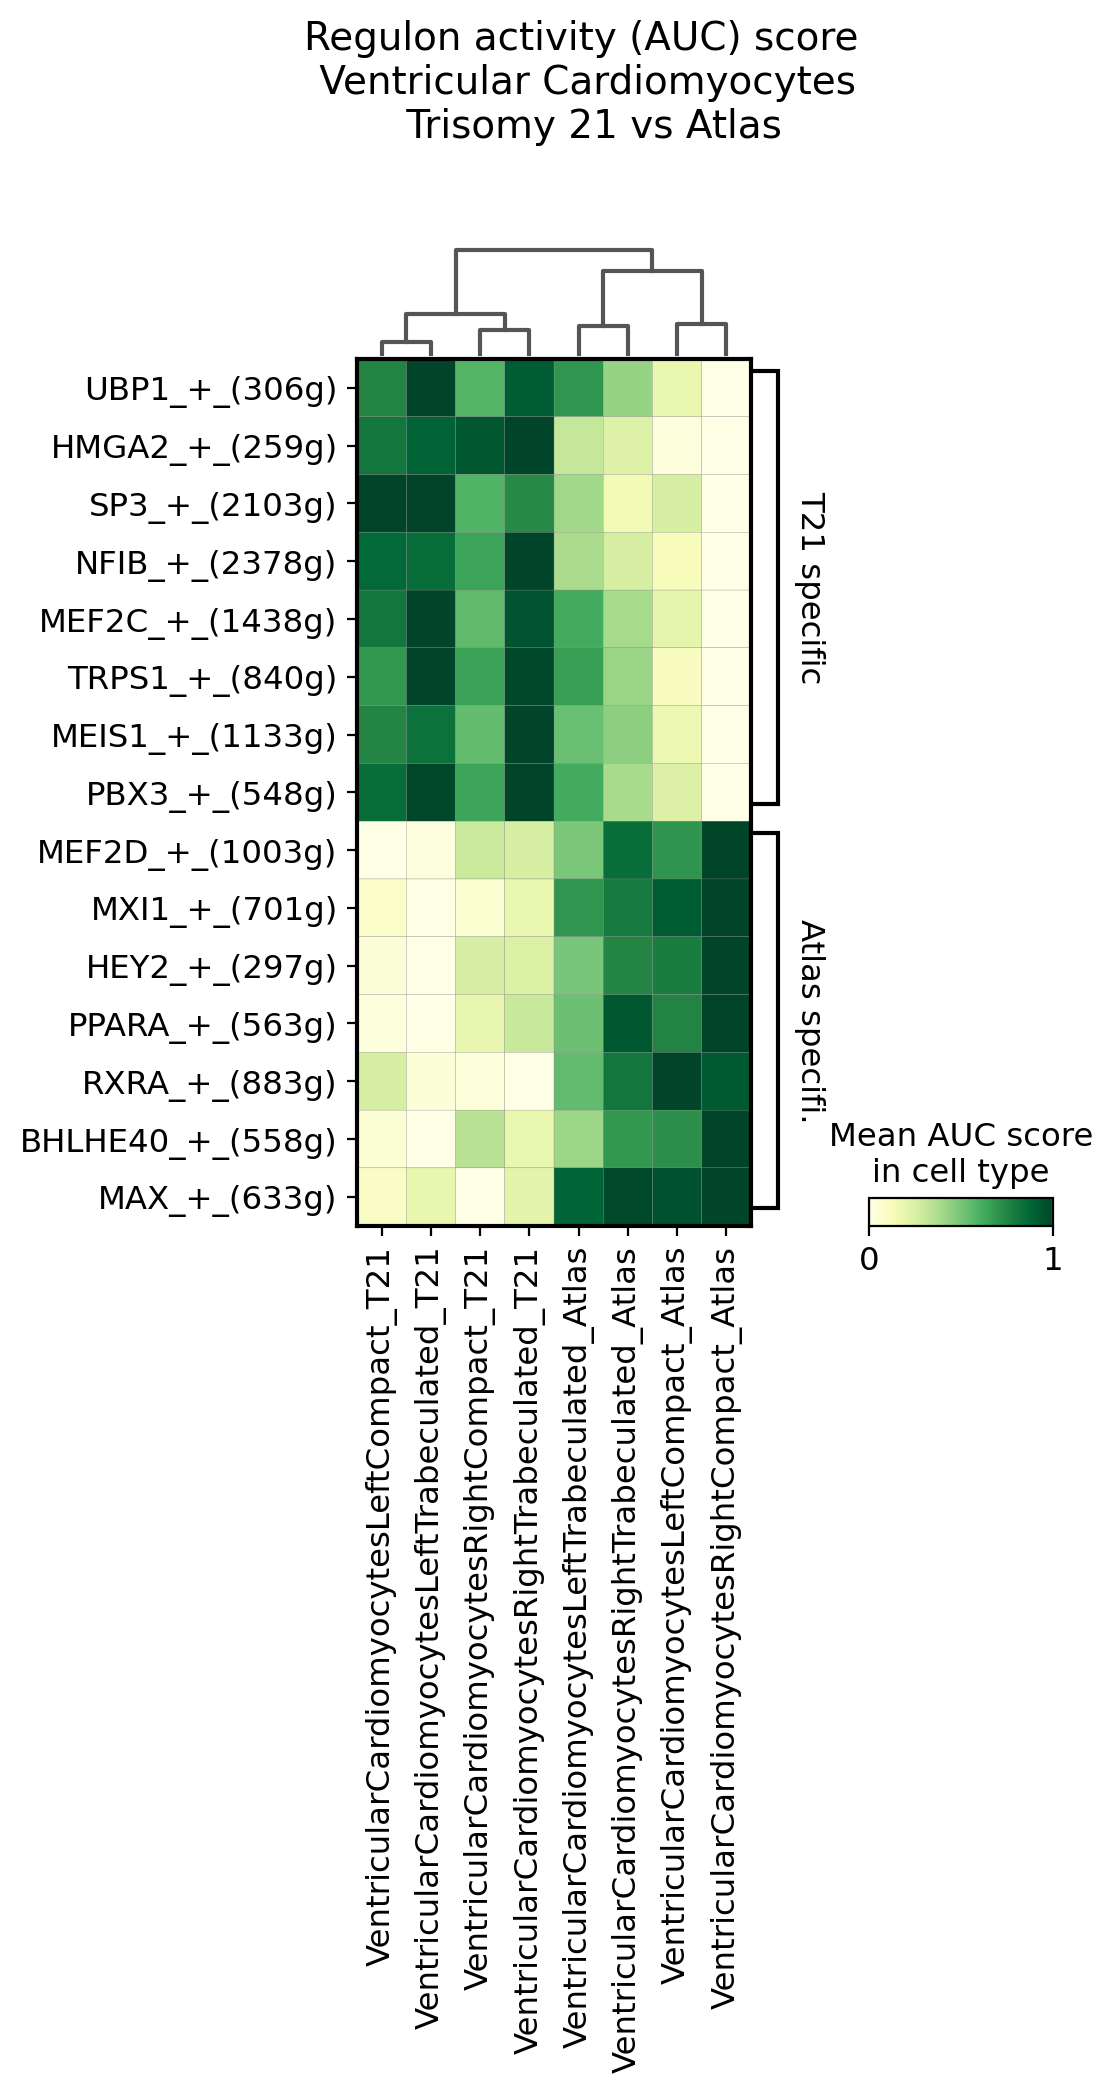


2023-06-29 20:28:56 ERROR : Local file system at /lustre/scratch126/cellgen/team205/jc48/jupyter/scArches/fetal/5_DEG_testing/figures/AUCAtlasT21vCM.svg: error reading source root directory: directory not found
Transferred:   	          0 B / 0 B, -, 0 B/s, ETA -
Elapsed time:         1.4s
2023-06-29 20:28:56 ERROR : Attempt 1/3 failed with 1 errors and: directory not found
Transferred:   	          0 B / 0 B, -, 0 B/s, ETA -
Errors:                 1 (retrying may help)
Elapsed time:         1.4s
2023-06-29 20:28:56 ERROR : Local file system at /lustre/scratch126/cellgen/team205/jc48/jupyter/scArches/fetal/5_DEG_testing/figures/AUCAtlasT21vCM.svg: error reading source root directory: directory not found
Transferred:   	          0 B / 0 B, -, 0 B/s, ETA -
Elapsed time:         1.6s
2023-06-29 20:28:56 ERROR : Attempt 2/3 failed with 1 errors and: directory not found
Transferred:   	          0 B / 0 B, -, 0 B/s, ETA -
Errors:                 1 (retrying may help)
Elapsed time:       

In [144]:
tmp_adata_reg=adata_reg[adata_reg.obs.fine_grain_integrated.isin(vCM_list)]

filename="AUCAtlasT21vCM.svg"

sc.pl.matrixplot(tmp_adata_reg,
             groupby="fine_grain_T21_status",
             var_names=var_dict,
               standard_scale="var",
                 swap_axes=True,
                dendrogram=True,
                cmap="YlGn",
                   title="Regulon activity (AUC) score \n Ventricular Cardiomyocytes \n Trisomy 21 vs Atlas",
                   save=filename,
                colorbar_title="Mean AUC score\nin cell type")

filepath=os.path.join(os.getcwd(),"figures",filename)
! /software/rclone/rclone copy {filepath} gdrive:Sanger-CSCI_data_share/Manuscript/Figures/Figure6 --drive-shared-with-me --progress